# Part 1: Learn how to play Tic-Tac-Toe with reinforcement learning

Implement simple tictactoe game in Python with text-based output and learn how to play it using the Minmax algorithm, tabular Q-learning and deep Q-learning with dense neural networks using a dual network architecture, dueling network and (prioritised) experience replay. The neural networks are implemented using Keras and TensorFlow. I took inspiration and validated the results with Casten Friedrich's tutorial on implementing reinforcement agents for tictactoe https://github.com/fcarsten/tic-tac-toe.

See the blog post https://kunkelalexander.github.io/blog/computers-learning-tic-tac-toe-tabular-q/ for more information. 

# Setup

Include dependencies, set up plot style and define a few helper functions for plotting. 

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go
import numpy as np
import tensorflow as tf
from PIL import Image
import io
import random
import os


from src.tictactoe import TicTacToe
from src.game_manager import GameManager
from src.training_manager import TrainingManager
from src.agent_tabular_q import TabularQAgent
from src.agent_random import RandomAgent
from src.agent_minmax import MinMaxAgent
from src.gui import ascii_gui

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_seed(42)

# Force TensorFlow into deterministic op mode (TF 2.x)
tf.config.experimental.enable_op_determinism()

# Output resolution
DPI = 400


# Get 3 colors from the magma colormap (evenly spaced)
magma_cmap = cm.get_cmap('magma')
colors = [magma_cmap(i) for i in [0.2, 0.5, 0.8]]  # Dark to light
p2_color   = colors[0]
p1_color   = colors[1]
draw_color   = colors[2]

def plot_neon(results_dict, title, colors, labels, filename):
    agents = results_dict["agents"]
    results = results_dict["results"]

    episodes = results["evaluation_episodes"]
    metrics = results["metrics"]

    num_episodes = len(episodes)
    num_agents = len(agents)

    # Stack: [agent1_win, agent2_win, ..., draw] (shape: episodes x (n_agents + 1))
    victory_rates = np.column_stack([metrics[f"victory_rate_{agent.name}"] for agent in agents])
    draw_rates = np.array(metrics["draw_rate"])
    all_rates = np.hstack([victory_rates, draw_rates.reshape(-1, 1)])


    # Create figure
    fig, ax = plt.subplots(figsize=(5, 3), dpi=DPI)
    plt.axis("off")

    x = np.arange(1, num_episodes+1)
    bottom = np.zeros(num_episodes)

    for i in range(num_agents + 1):
        bar = ax.bar(
            x+0.5, all_rates[:, i],
            bottom=bottom,
            color=colors[i],
            edgecolor='black',
            label=labels[i],
            width=1.0
        )

        # Add percentage text
        for rect, rate in zip(bar, all_rates[:, i]):
            if rate > 0.05:  # Skip tiny percentages
                height = rect.get_height()
                ax.text(
                    rect.get_x() + rect.get_width() / 2,
                    rect.get_y() + height / 2,
                    f"{int(rate * 100)}%",
                    ha='center',
                    va='center',
                    fontsize=5,
                    color='white',
                    fontweight="bold"
                )
        bottom += all_rates[:, i]

    # Remove y-axis and spines
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.tick_params(axis='x', colors='white')

    # Title and x-label
    ax.set_title(title,  color='black', fontweight="bold")
    ax.set_xlabel("Episode", color='white')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=8,
          ncol=3, fancybox=True, shadow=True)


    plt.tight_layout()
    plt.savefig(filename, dpi=DPI, bbox_inches='tight')
    plt.show()
    plt.close()

def compare_training_runs(runs_outputs, run_names, colors, labels, filename, title="Training Run Comparison"):
    """
    Plots a stacked bar chart comparing the final evaluation snapshot of multiple training runs.

    Parameters:
        runs_outputs (list of dicts): Each item is a dict with keys 'agents' and 'results'
        run_names (list of str): Names of the training runs, used as x-axis labels
        colors (list): Colors for bars (one per agent + draw)
        labels (list): Labels (e.g. ["Agent A", "Agent B", "Draw"])
        filename (str): Output file path to save the figure
        title (str): Title of the plot
    """
    num_runs = len(runs_outputs)
    num_categories = len(labels)

    all_last_rates = []

    for run in runs_outputs:
        agents = run["agents"]
        metrics = run["results"]["metrics"]

        last_victory = [metrics[f"victory_rate_{agent.name}"][-1] for agent in agents]
        last_draw = metrics["draw_rate"][-1]

        all_last_rates.append(np.array(last_victory + [last_draw]))

    all_last_rates = np.array(all_last_rates)  # shape: (num_runs, num_categories)


    # Plot setup
    fig, ax = plt.subplots(figsize=(5, 3), dpi=DPI)

    x = np.arange(num_runs)  # Run positions
    bar_width = 0.8
    bottoms = np.zeros(num_runs)

    for i in range(num_categories):
        bar = ax.bar(
            x,
            all_last_rates[:, i],
            bottom=bottoms,
            color=colors[i],
            edgecolor='black',
            label=labels[i],
            width=bar_width
        )

        # Add percentage text
        for rect, rate in zip(bar, all_last_rates[:, i]):
            if rate > 0.05:
                height = rect.get_height()
                ax.text(
                    rect.get_x() + rect.get_width() / 2,
                    rect.get_y() + height / 2,
                    f"{int(rate * 100)}%",
                    ha='center',
                    va='center',
                    fontsize=5,
                    color='white',
                    fontweight="bold"
                )
        bottoms += all_last_rates[:, i]

    # Axes and labels
    ax.set_xticks(x)
    ax.set_xticklabels(run_names, rotation=0, color='black', fontsize=8)
    # Optional: create space below bars for labels
    ax.tick_params(axis='x', which='both', length=0)

    ax.set_yticks([])
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)  # or True if you want a line

    ax.set_title(title, color='black', fontweight="bold")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=8,
              ncol=3, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.savefig(filename, dpi=DPI, bbox_inches='tight')
    plt.show()
    plt.close()


class GifRecorder:
    def __init__(self, board_size, agent_symbols=None, labels=None):
        self.frames = []
        self.board_size = board_size
        self.agent_symbols = agent_symbols or {1: "X", 2: "◯"}
        self.labels = labels or ["P1\nwins", "P2\nwins", "Draw"]
        self.cmap = cm.get_cmap('magma')
        self.current_game = 1
        self.new_game_flag = True
        self.pending_annotation = None  # (text, color)

    def record_frame(self, board, agent_id=None, events=None, game_over=False):
        fig, ax = plt.subplots(figsize=(5, 3), dpi=DPI)
        plt.style.use('classic')
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_xlim(-1.5, self.board_size)
        ax.set_ylim(0, self.board_size)

        # --- Game number ---
        ax.text(-0.85, self.board_size / 2 + 0.6,
                f"Game\n{self.current_game}",
                ha='center', va='center',
                fontsize=18, fontweight='bold',
                color='black', linespacing=1.8)

        # --- Win/Draw annotation ---
        if self.pending_annotation:
            text, color = self.pending_annotation
            ax.text(-0.85, self.board_size / 2 - 0.9,
                    text,
                    ha='center', va='center',
                    fontsize=18, fontweight='bold',
                    color=color)

        self.new_game_flag = False

        # --- Grid ---
        for x in range(1, self.board_size):
            ax.plot([x, x], [0, self.board_size], color='black', linewidth=2)
            ax.plot([0, self.board_size], [x, x], color='black', linewidth=2)

        # --- Symbols ---
        for y in range(self.board_size):
            for x in range(self.board_size):
                cell = board[y, x]
                if cell in self.agent_symbols:
                    symbol = self.agent_symbols[cell]
                    color_idx = 0.2 if cell == 1 else 0.8
                    color = p1_color if cell == 1 else p2_color

                    # Shadow
                    for dx, dy in [(-0.03, -0.03), (0.03, 0.03), (-0.03, 0.03), (0.03, -0.03)]:
                        ax.text(x + 0.5 + dx, self.board_size - y - 0.5 + dy,
                                symbol, ha='center', va='center',
                                fontsize=28, color='black', alpha=0.8, weight='bold')
                    # Main symbol
                    ax.text(x + 0.5, self.board_size - y - 0.5,
                            symbol, ha='center', va='center',
                            fontsize=28, color=color, weight='bold')

        # --- Save Frame ---
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.05, dpi=DPI)
        buf.seek(0)
        img = Image.open(buf).convert('RGB')
        self.frames.append(img)
        plt.close()

        # --- On Game Over: set up annotation and insert a pause frame ---
        if game_over:
            if (("VICTORY" in events) and (agent_id == 1)) or (("DEFEAT" in events) and (agent_id == 2)):
                result_text, color = self.labels[0], p1_color
            elif (("VICTORY" in events) and (agent_id == 2)) or (("DEFEAT" in events) and (agent_id == 1)):
                result_text, color = self.labels[1], p2_color
            elif "DRAW" in events:
                result_text, color = self.labels[2], draw_color
            else:
                raise ValueError("Game over but no corresponding event")

            self.pending_annotation = (result_text, color)

            # Show annotated final frame longer (e.g. 2 sec @ 5 fps)
            for _ in range(10):  # 10 frames = 2 sec @ 200 ms/frame
                self.record_frame(board)

            self.insert_pause_frame(seconds=1)
            self.current_game += 1
            self.new_game_flag = True
            self.pending_annotation = None


    def insert_pause_frame(self, seconds=1, fps=5):
        if not self.frames:
            return
        last = self.frames[-1]
        pause_frames = [last.copy() for _ in range(seconds * fps)]
        self.frames.extend(pause_frames)

    def save_gif(self, path, duration=200):
        if self.frames:
            self.frames[0].save(path,
                                save_all=True,
                                append_images=self.frames[1:],
                                duration=duration,
                                loop=0)

def make_gif_gui(recorder):
    def gif_gui(game, agent_id, events, game_over):
        recorder.record_frame(game.board, agent_id, events, game_over)
    return gif_gui

def plot_q_table(q, q_ref=None, start_index=0, max_states=None, xlabel="States ordered by # valid moves (9 → 1)", order = None, vmin=None, vmax=None):

    if not order:
        # 1. Depth: number of legal (finite) actions per state
        depth = np.isfinite(q_ref if q_ref is not None else q).sum(axis=1)

        # 2. Sort states by descending depth
        order = np.argsort(-depth)
        depth_sorted = depth[order]

        # 3. Filter out states with 0 legal actions
        valid_mask = depth_sorted > 0
        order = order[valid_mask]
        depth_sorted = depth_sorted[valid_mask]

        # 4. Apply start index and optional max_states filter
        order = order[start_index:]
        if max_states is not None:
            order = order[:max_states]

    q_sorted = q[order]  # (N_states, 9)

    # -----------------------------------------------------------
    # 1.  Make an HTML-ready 3 × 3 board
    # -----------------------------------------------------------
    def idx_to_board_html(idx):
        """Return an HTML string like
        <span style="font-family:monospace"> XO<br> XO<br>&nbsp; O</span>"""
        # use &nbsp; so empty cells remain visible
        symbols  = np.array(['&nbsp;', 'X', 'O'])
        base3    = (idx // 3**np.arange(9)) % 3      # length-9, LL→UR
        rows     = [''.join(symbols[base3[r*3:(r+1)*3]]) for r in range(3)]
        return '<span style="font-family:monospace">' + '<br>'.join(rows) + '</span>'

    # -----------------------------------------------------------
    # 2.  Build the Plotly heat-map
    # -----------------------------------------------------------
    z          = q_sorted.T                              # 9 × N
    states     = order                                   # original state indices
    boards     = np.vectorize(idx_to_board_html)(states) # length-N HTML strings
    customdata = np.tile(boards, (9, 1))                 # repeat down 9 action rows


    action_labels = [
        "Upper left",   "Upper center",   "Upper right",
        "Center left",  "Center",         "Center right",
        "Bottom left",  "Bottom center",  "Bottom right"
    ]

    # Build a parallel string array for Q-value labels
    z_display = np.where(np.isneginf(z), "−inf", np.round(z, 3).astype(str))

    hovertemplate = (
        "State index: %{x}<br>"
        "Action: %{y}<br><br>"
        "Q-value: %{customdata[0]}<br><br>"
        "Board:<br>"
        "%{customdata[1]}"
        "<extra></extra>"
    )

    # Build new customdata with 2D array: [[q_display, board_html], ...]
    combined_customdata = np.empty(z.shape + (2,), dtype=object)
    combined_customdata[..., 0] = z_display
    combined_customdata[..., 1] = customdata  # customdata already contains board HTML

    # Replace z values that are -inf with nan so they render with a blank color
    z_safe = np.where(np.isneginf(z), np.nan, z)

    fig = go.Figure(go.Heatmap(
        z=z_safe,
        colorscale='Magma',
        customdata=combined_customdata,
        hovertemplate=hovertemplate,
        zmin=vmin,
        zmax=vmax,
        colorbar=dict(
            title="Q-value",
            tickfont=dict(family="DejaVu Sans", size=16)
        )
    ))

    fig.update_layout(

        margin=dict(
            pad=20
        ),
        autosize=True,                     # <-- remove fixed width/height
        yaxis=dict(tickmode='array', tickvals=list(range(9)), ticktext=action_labels, tickfont = dict(family='DejaVu Sans', size=20)),
        xaxis=dict(title=dict(text=xlabel, font=dict(family='DejaVu Sans', size=20)), tickfont = dict(family='DejaVu Sans', size=20)),
        plot_bgcolor='white',
        paper_bgcolor='white'

    )
    return fig

def normalize_q_table_to_greedy_mask(q: np.ndarray, atol: float = 1e-6) -> np.ndarray:
    """
    Transform a Q-table so that in each state, only the maximum Q-values
    (within numerical tolerance) are set to 1, and all others to -np.inf.

    :param q: Original Q-table (shape: [n_states, n_actions])
    :param atol: Absolute tolerance for comparing floating point equality
    :return: Transformed Q-table with 1 for greedy actions, -inf elsewhere
    """
    q_masked = np.full_like(q, -np.inf)

    for s in range(q.shape[0]):
        row = q[s]
        finite_mask = np.isfinite(row)

        if not np.any(finite_mask):
            q_masked[s, :] = 0.0
            continue

        max_val = np.max(row[finite_mask])

        # Find actions within atol of the maximum
        greedy_actions = np.isclose(row, max_val, atol=atol) & finite_mask
        q_masked[s, :] = 0.0

        q_masked[s, greedy_actions] = 1.0

    return q_masked





game = TicTacToe(board_size  = 3, agent_count = 2)
training_manager = TrainingManager( game = game,
                                    gui  = ascii_gui)

base_config = {
    "agent_types"         : ["RANDOM_AGENT", "RANDOM_AGENT"],
    "board_size"          : 3,
    "n_episode"           : 3000,   # Number of training episodes
    "n_eval"              : 100,    # Number of evaluation episodes every eval_freq training episodes
    "eval_freq"           : 100,
    "train_freq"          : 1,      # Train models every train_freq training episodes
    "grad_steps"          : 2,      # Number of gradient updates per training step
    "discount"            : 0.8,    # Discount in all Q learning algorithms
    "learning_rate_decay" : 1,
    "exploration"         : 1.0,    # Initial exploration rate
    "exploration_decay"   : 1e-2,   # Decrease of exploration rate for every action
    "exploration_min"     : 0.0,
    "learning_rate"       : 1e-2,
    "randomise_order"     : False,  # Randomise starting order of agents for every game
    "only_legal_actions"  : True,   # Have agents only take legal actions
    "debug"               : False,  # Print loss and evaluation information during training
    "plot_debug"          : False,  # Plot game outcomes
    "batch_size"          : 128,    # Batch size for DQN algorithm
    "replay_buffer_size"  : 10000,  # Replay buffer for DQN algorithm
    "replay_buffer_min"   : 1000,   # minimum size before we start training
    "target_update_tau"   : 0.1,    # Weight for update in dual DQN architecture target = (1 - tau) * target + tau * online
    "target_update_freq"  : 10,     # Update target network every n episodes
    "target_update_mode"  : "hard", # "hard": update every target_update freq or "soft": update using Polyakov rule with target_update_tau
    "initial_q"           : 0.6,    # Initial Q value for tabular Q learning
    "board_encoding"      : "encoding_tutorial"
}

runs = {}

2025-07-27 16:38:03.556285: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 16:38:03.609701: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 16:38:03.611457: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-27 16:38:04.755760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Figures

## Figure 0: Introductory animation

In [7]:
from src.agent_random import RandomAgent
from src.agent_minmax import MinMaxAgent

# Setup before the game
recorder = GifRecorder(board_size=3)
gif_gui = make_gif_gui(recorder)
minmax_agent1 = MinMaxAgent(1, 9, n_states=3**9, game=TicTacToe(board_size  = 3, agent_count = 2), act_randomly=True)
minmax_agent2 = MinMaxAgent(2, 9, n_states=3**9, game=TicTacToe(board_size  = 3, agent_count = 2), act_randomly=True)
agents = [minmax_agent1, minmax_agent2]
game_manager = GameManager(game=game, agents=agents, gui=gif_gui)
for i in range(5):
    game_manager.run_game(do_training=True, randomise_order=False, only_legal_actions=True, debug=False)

# After game
recorder.save_gif("figures/1_minimax_vs_minimax_game_play.gif")

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:07<00:00, 2802.40it/s] 


Initializing random MinMax agent 2


100%|██████████| 19683/19683 [00:06<00:00, 3042.85it/s] 


## Figure 1: Minimax agent vs random agent

In [2]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "RANDOM_AGENT"]
config["eval_freq"]     = 3000
config["n_eval"]        = 10000
out = training_manager.run_training(config)
runs["random vs random"] = out

In [3]:
config = dict(base_config)
config["agent_types"]   = ["MINMAX_AGENT", "RANDOM_AGENT"]
config["eval_freq"]     = 3000
config["n_eval"]        = 10000
out = training_manager.run_training(config)
runs["minimax vs random"] = out

Initializing MinMax agent 1


100%|██████████| 19683/19683 [00:06<00:00, 2864.30it/s] 


In [4]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "MINMAX_AGENT"]
config["eval_freq"]     = 3000
config["n_eval"]        = 10000
out = training_manager.run_training(config)
runs["random vs minimax"] = out

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:07<00:00, 2809.15it/s] 


In [5]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "RANDOM_MINMAX_AGENT"]
config["eval_freq"]     = 3000
config["n_eval"]        = 10000
out = training_manager.run_training(config)
runs["minimax vs minimax"] = out

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:06<00:00, 2938.06it/s] 


Initializing random MinMax agent 2


100%|██████████| 19683/19683 [00:07<00:00, 2717.73it/s] 


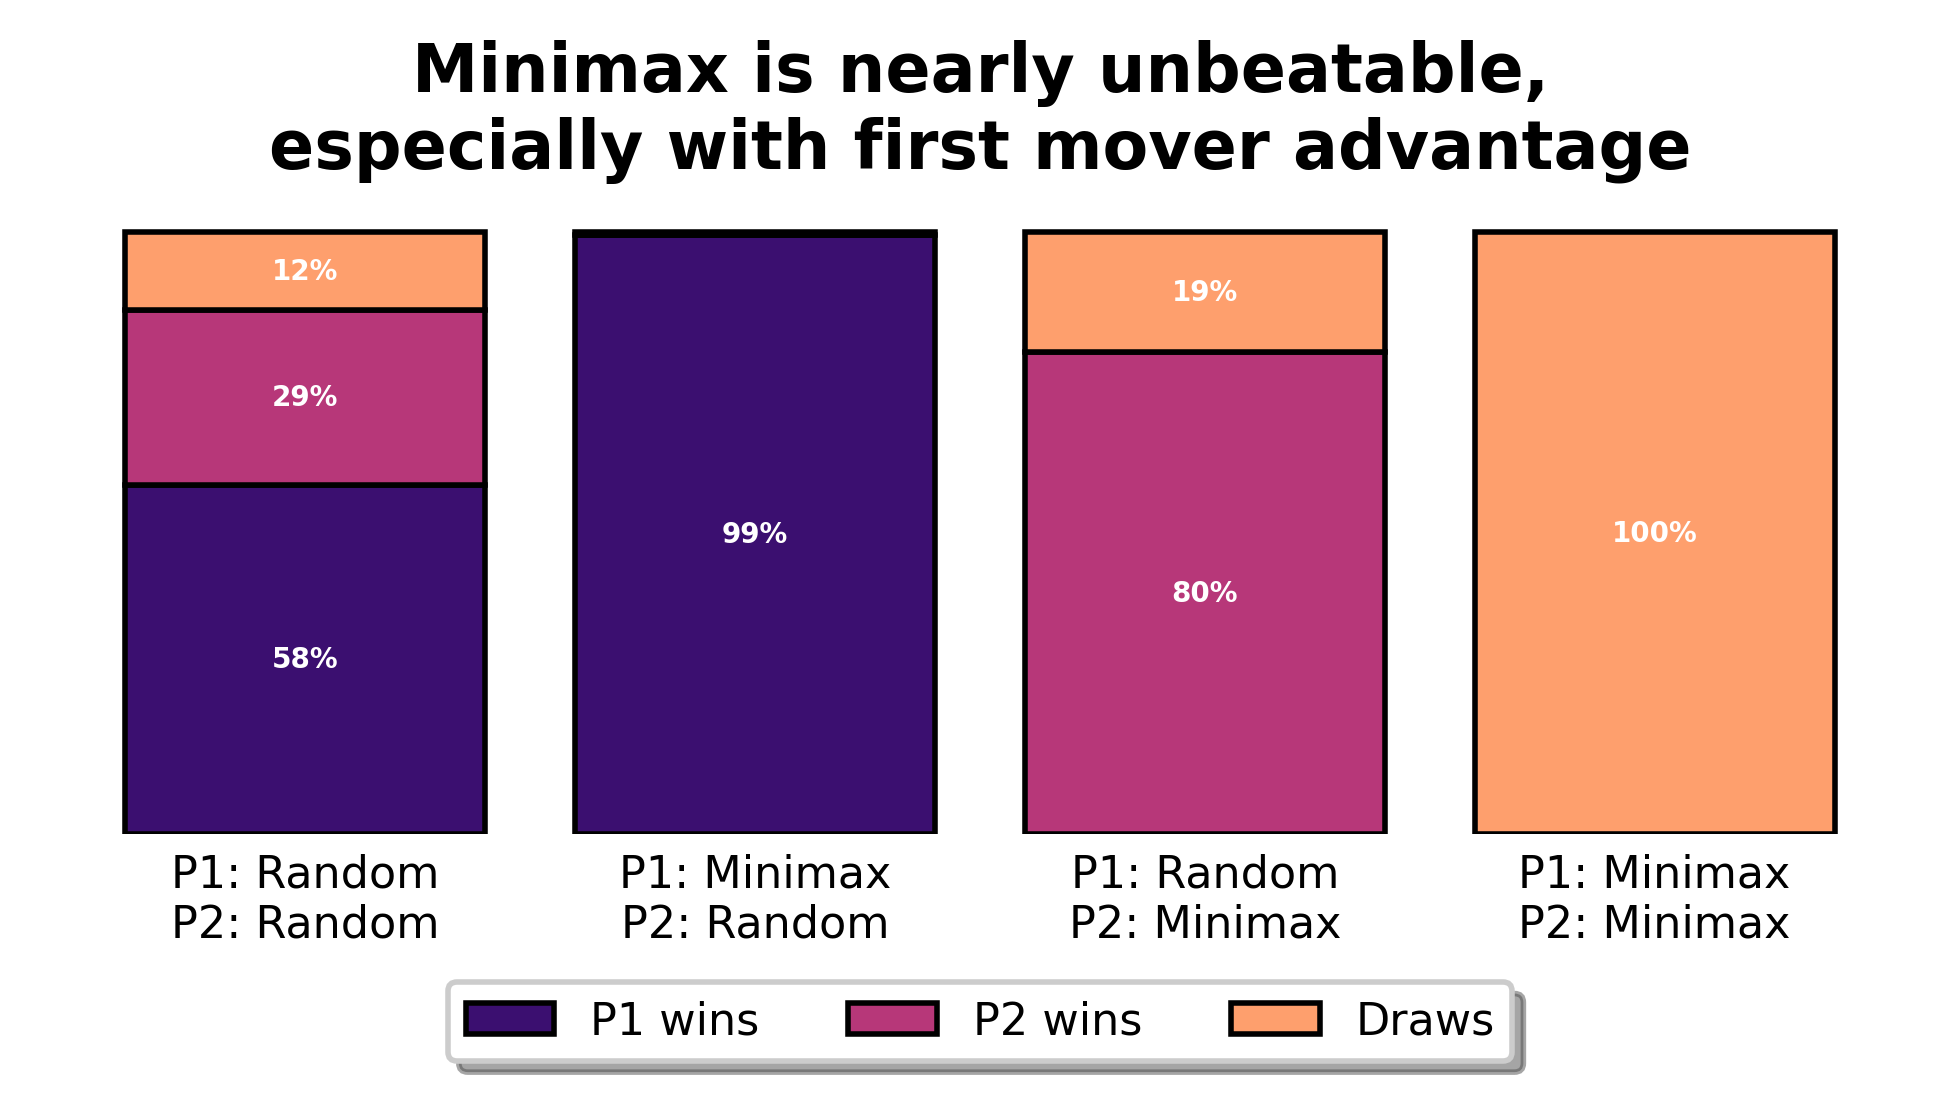

In [6]:
compare_training_runs([runs["random vs random"], runs["minimax vs random"], runs["random vs minimax"], runs["minimax vs minimax"]],
                      ["P1: Random\nP2: Random", "P1: Minimax\nP2: Random", "P1: Random\nP2: Minimax", "P1: Minimax\nP2: Minimax"],
                      colors = colors,
                      labels = ["P1 wins", "P2 wins", "Draws"],
                      filename = "figures/1_random_minimax_comparison.png",
                      title="Minimax is nearly unbeatable,\nespecially with first mover advantage")

## Figure 2: Tabular Q-Learning vs random agent

In [8]:
config = dict(base_config)

config["n_episode"]           = 30000
config["n_eval"]              = 3000
config["eval_freq"]           = 3000
trained_q_agent = TabularQAgent(2, 9, 3**9, config)
agents = [RandomAgent(1, 9),trained_q_agent]

out = training_manager.run_training(config, agents)
runs["random vs q"] = out

/tmp/ipykernel_179151/3597427441.py:108: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


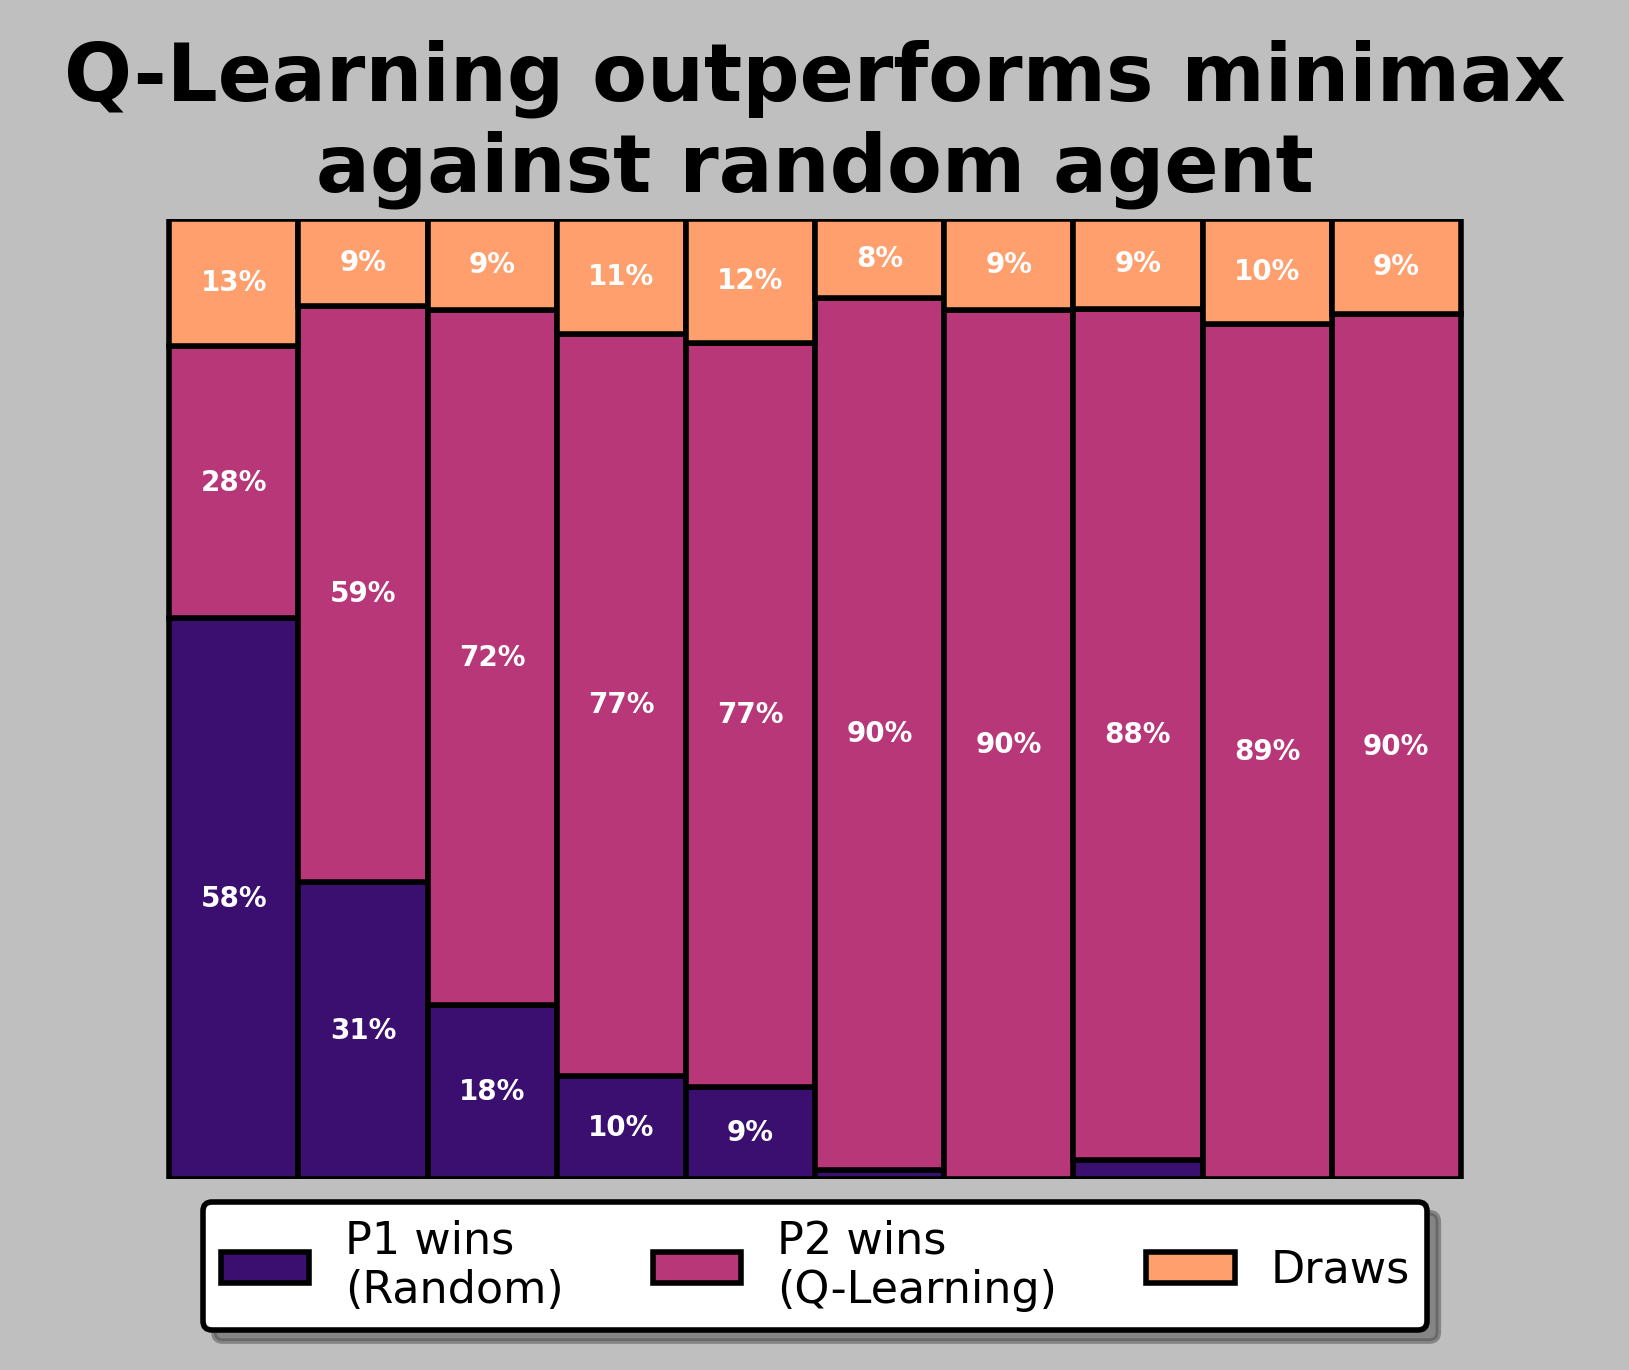

In [9]:
plot_neon(runs["random vs q"], title = "Q-Learning outperforms minimax\nagainst random agent", colors = colors, labels = ["P1 wins\n(Random)", "P2 wins\n(Q-Learning)", "Draws"], filename = "figures/2_random_vs_q.png")

## Figure 3: Q-table of tabular Q-learning algorithm playing second against a random player

In [11]:
config = dict(base_config)

config["n_episode"]           = 100000
config["n_eval"]              = 1000
config["eval_freq"]           = 100000
config["exploration_decay"]   = 1e-5
config["exploration_min"]     = 0.0
config["initial_q"]           = 0.6
trained_q_agent = TabularQAgent(2, 9, 3**9, config)
agents = [RandomAgent(1, 9), trained_q_agent]
minmax_agent = MinMaxAgent(2, 9, 3**9, game, True)

out = training_manager.run_training(config, agents)


Initializing random MinMax agent 2


100%|██████████| 19683/19683 [00:08<00:00, 2224.10it/s] 


In [12]:
from src.tictactoe import TicTacToe

q1 = trained_q_agent.q.copy()
q2 = minmax_agent.q.copy()

for i in range(q1.shape[0]):
    game = TicTacToe(3, 2)
    game.set_state(i)
    if not game.is_valid_state(starting_agent_id=1, perspective_agent_id=2):
        q1[i, :] = -np.inf
        q2[i, :] = -np.inf

In [13]:
fig = plot_q_table(q1)
fig.show()
fig.write_html("figures/3_q_agent_q_table.html", include_plotlyjs='directory')

## Figure 4: Q-table of the random minimax agent

In [14]:
fig = plot_q_table(q2, q1)
fig.show()
fig.write_html("figures/4_minimax_agent_q_table.html", include_plotlyjs='directory')

## Figure 5: Q-table of the tabular Q-learning algorithm vs deterministic minimax agent

In [15]:
config = dict(base_config)

config["n_episode"]           = 50000
config["eval_freq"]           = 1000
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05

minmax_agent    = MinMaxAgent(1, 9, 3**9, game, False)
trained_q_agent = TabularQAgent(2, 9, 3**9, config)
agents = [minmax_agent, trained_q_agent]
minmax_agent_second = MinMaxAgent(2, 9, 3**9, game, True)

out = training_manager.run_training(config, agents)


q1 = trained_q_agent.q.copy()
q2 = minmax_agent_second.q.copy()

for i in range(q1.shape[0]):
    game = TicTacToe(3, 2)
    game.set_state(i)
    if not game.is_valid_state(starting_agent_id=1, perspective_agent_id=2):
        q1[i, :] = -np.inf
        q2[i, :] = -np.inf


Initializing MinMax agent 1


100%|██████████| 19683/19683 [00:10<00:00, 1817.92it/s] 


Initializing random MinMax agent 2


100%|██████████| 19683/19683 [00:09<00:00, 2155.05it/s] 


In [16]:
fig = plot_q_table(q1, start_index=2070)
fig.show()
fig.write_html("figures/5_det_minmax_vs_q_agent_q_table.html", include_plotlyjs='directory')

## Figure 6: Q-table of the minimax agent playing second against itself

In [17]:
fig = plot_q_table(q2, q1, start_index=2070)
fig.show()
fig.write_html("figures/6_det_minmax_vs_minmax_q_table.html", include_plotlyjs='directory')